# Set up

In [71]:
import glob
import datetime as dt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import pytz

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# EDA

## Load flight data from CSV

In [251]:
# load data from The U.S. Department of Transportation's
mypath="./data/Flights-2017*.csv"
csvFileList= (glob.glob(mypath))

count=0
for f in csvFileList:
    if (count==0):
        flights=pd.read_csv(f, parse_dates= [
            'FL_DATE','DEP_TIME', 'ARR_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME'])
    else:
        tmp=pd.read_csv(f, parse_dates= [
            'FL_DATE','DEP_TIME', 'ARR_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME'])
        flights=flights.append(tmp, ignore_index=True, sort=False)
    count+=1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12


In [252]:
flights.dtypes

YEAR                            int64
MONTH                           int64
DAY_OF_MONTH                    int64
FL_DATE                datetime64[ns]
OP_CARRIER                     object
TAIL_NUM                       object
ORIGIN_AIRPORT_ID               int64
ORIGIN                         object
DEST_AIRPORT_ID                 int64
DEST                           object
CRS_DEP_TIME                   object
DEP_TIME                       object
DEP_DELAY                     float64
DEP_DELAY_NEW                 float64
TAXI_OUT                      float64
WHEELS_OFF                    float64
WHEELS_ON                     float64
TAXI_IN                       float64
CRS_ARR_TIME                   object
ARR_TIME                       object
ARR_DELAY                     float64
CANCELLED                     float64
DIVERTED                      float64
CRS_ELAPSED_TIME              float64
ACTUAL_ELAPSED_TIME           float64
AIR_TIME                      float64
DISTANCE    

In [8]:
airports=pd.read_csv('./data/airports.csv')

In [9]:
airports.size

2254

In [10]:
airlines=pd.read_csv('./data/airlines.csv')

In [253]:
print('Total flight rows are: '+str(flights['ORIGIN'].size))

Total flight rows are: 5666838


## Save to pickle for easy loading in future

In [254]:
flights.to_pickle('./data/flights.pkl')

In [16]:
airports.to_pickle('./data/airports.pkl')

In [17]:
airlines.to_pickle('./data/airlines.pkl')

## Load pickle files

In [6]:
flights=pd.read_pickle('./data/flights.pkl')

In [7]:
airports=pd.read_pickle('./data/airports.pkl')

In [8]:
airlines=pd.read_pickle('./data/airlines.pkl')

## Clean and merge airport and volume data

In [9]:
airport_vol=pd.read_csv('./data/airport_volume.csv')

In [10]:
airports=airports.merge(airport_vol, left_on='IATA_CODE', right_on='IATA_CODE', how='inner', left_index=True)

In [11]:
airports=airports.rename(columns={'PASS_DEPART': 'PASS_DEPART(K)'})

In [12]:
airports['PASS_DEPART(K)']=airports['PASS_DEPART(K)'].str.replace('k','')
airports['PASS_DEPART(K)']=airports['PASS_DEPART(K)'].str.replace(',','')
airports['FLIGHT_DEPART']=airports['FLIGHT_DEPART'].str.replace(',','')

In [13]:
airports['PASS_DEPART(K)']=pd.to_numeric(airports['PASS_DEPART(K)'])
airports['FLIGHT_DEPART']=pd.to_numeric(airports['FLIGHT_DEPART'])

In [14]:
airports=airports.drop(columns=['COUNTRY', 'Unnamed: 0', 'PASS_DEPART(K)'])

In [15]:
airports.dropna(subset=['LONGITUDE'], inplace=True)

In [16]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,LATITUDE,LONGITUDE,FLIGHT_DEPART
0,ABE,Lehigh Valley International Airport,Allentown,PA,40.65236,-75.44040,6230
1,ABI,Abilene Regional Airport,Abilene,TX,32.41132,-99.68190,3041
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,35.04022,-106.60919,29424
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,45.44906,-98.42183,1007
4,ABY,Southwest Georgia Regional Airport,Albany,GA,31.53552,-84.19447,1479


In [17]:
tmp=airports.loc[:,['LONGITUDE', 'LATITUDE']]

In [18]:
# Get timezone data for airport
from timezonefinder import TimezoneFinder
get_tz = TimezoneFinder().timezone_at
airports['TIMEZONE']=tmp.apply(lambda x: get_tz(lng=x['LONGITUDE'], lat=x['LATITUDE']),axis=1)

## Merge flights with airport data

In [244]:
# rows are dropped as a result of the merge, where airport codes cannot be matched
flights2=flights.merge(airports, left_on='ORIGIN', right_on='IATA_CODE', how='inner')

In [253]:
flights2.columns

Index(['MONTH', 'DAY_OF_MONTH', 'FL_DATE', 'TAIL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ORIG_FLIGHTS_DEPART_VOL', 'ORIGIN_TIMEZONE', 'DEP_DT',
       'ARR_DT'],
      dtype='object')

In [246]:
flights2=flights2[['MONTH', 'DAY_OF_MONTH', 'FL_DATE', 'TAIL_NUM', 'ORIGIN', 'DEST','CRS_DEP_TIME', 'DEP_TIME', 
                   'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME','ARR_DELAY', 'FLIGHT_DEPART', 'TIMEZONE']]

In [247]:
flights2=flights2.rename(columns={'TIMEZONE':'ORIGIN_TIMEZONE', 'FLIGHT_DEPART':'ORIG_FLIGHTS_DEPART_VOL'})

In [248]:
print('Total flights with departure data are after cleaning: '+str(flights2['ORIGIN'].size))

Total flights with departure data are after cleaning: 5660068


## Get and clean weather data

In [231]:
weather=pd.read_pickle('./data/airport_weather.pkl')

In [232]:
# reduce rows by taking mean of records per 3-hour interval per station
weather=weather.groupby('Station').resample('3H', on='Record_time').mean()

In [233]:
# reset index to one level
weather.reset_index(inplace=True)

In [234]:
# drop column that's not useful
weather=weather.drop(columns=['Gust_MP'])

In [235]:
# rows are dropped as a result of the merge with non-matching airports 
weather2=weather.merge(airports, left_on='Station', right_on='IATA_CODE', 
                       how='inner')

In [236]:
weather2['TZ']=weather2['TIMEZONE'].apply(pytz.timezone)

In [240]:
weather2.dtypes

Station                       object
Record_time           datetime64[ns]
Temp_F                       float64
WindSpeed                    float64
Precip                       float64
IATA_CODE                     object
AIRPORT                       object
CITY                          object
STATE                         object
LATITUDE                     float64
LONGITUDE                    float64
FLIGHT_DEPART                  int64
TIMEZONE                      object
TZ                            object
TIME_UTC         datetime64[ns, UTC]
dtype: object

In [238]:
weather2['TIME_UTC']=weather2.apply(lambda x: x['Record_time'].tz_localize(tz=x['TIMEZONE']).tz_convert('utc'), 
                                    axis=1)

In [239]:
weather2.to_pickle('./data/airport_weather2.pkl')

In [241]:
weather2=weather2[['IATA_CODE', 'TIME_UTC', 'Temp_F', 'WindSpeed', 'Precip']]

## Explore and clean flights data

In [249]:
# drop flights that did not have departure delay data (e.g. cancelled)
flights2.dropna(subset=['DEP_DELAY'], inplace=True)

In [250]:
# Fix times that are 24:00 which is not acceptible in Python
time_filter=(flights2['DEP_TIME']=='2400')
flights2.loc[time_filter,['DEP_TIME']]='0000'
flights2.loc[time_filter,['FL_DATE']]+=timedelta(days=1)

In [251]:
# convert to time for time columns
flights2['DEP_DT']=pd.to_datetime(flights2['FL_DATE'].map(str).str.slice(0,10)+' '+
                                  flights2['DEP_TIME'].map(str), format='%Y-%m-%d %H%M', errors='coerce')
flights2['ARR_DT']=pd.to_datetime(flights2['FL_DATE'].map(str).str.slice(0,10)+' '+
                                  flights2['ARR_TIME'].map(str), format='%Y-%m-%d %H%M', errors='coerce')

In [262]:
flights2.dropna(subset=['ORIGIN_TIMEZONE'], inplace=True)

In [206]:
flights2.dtypes

DEP_DELAY                          float64
MONTH                                int64
DAY_OF_MONTH                         int64
OP_CARRIER                          object
INBOUND_DELAY                      float64
TURNAROUND_TIME            timedelta64[ns]
ORIG_FLIGHTS_DEPART_VOL              int64
dtype: object

In [264]:
flights2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5580649 entries, 0 to 5660067
Data columns (total 16 columns):
MONTH                      int64
DAY_OF_MONTH               int64
FL_DATE                    object
TAIL_NUM                   object
ORIGIN                     object
DEST                       object
CRS_DEP_TIME               object
DEP_TIME                   object
DEP_DELAY                  float64
CRS_ARR_TIME               object
ARR_TIME                   object
ARR_DELAY                  float64
ORIG_FLIGHTS_DEPART_VOL    int64
ORIGIN_TIMEZONE            object
DEP_DT                     datetime64[ns]
ARR_DT                     datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(9)
memory usage: 723.8+ MB


In [265]:
flights2['TZ']=flights2['ORIGIN_TIMEZONE'].apply(pytz.timezone)

In [ ]:
# create column for departure time in UTC (note: it's key to use 'localize' to account for DST datetimes)
flights2['DEP_DT_UTC']=flights2.apply(lambda x: x['TZ'].localize(x['DEP_DT']).tz_convert('utc'), axis=1)

In [267]:
flights2=flights2.sort_values(by=['TAIL_NUM', 'DEP_DT_UTC'])

In [268]:
# create new column to account for delays due to inbound plane
flights2['INBOUND_DELAY']=flights2.groupby('TAIL_NUM')['ARR_DELAY'].apply(lambda x: x.shift(1))

In [269]:
# add new column for plane turnaround time between flights
flights2['PREV_ARR_DT']=flights2.groupby('TAIL_NUM')['ARR_DT'].shift(1)

In [271]:
flights2.dropna(subset=['INBOUND_DELAY'], inplace=True)

In [272]:
flights2.dropna(subset=['PREV_ARR_DT'], inplace=True)

In [273]:
tmp=flights2[['TZ', 'PREV_ARR_DT']]

In [274]:
flights2['PREV_ARR_DT_UTC']=tmp.apply(lambda x: x['TZ'].localize(
                                                       x['PREV_ARR_DT']).tz_convert('utc'), axis=1)

In [275]:
flights2['TURNAROUND_TIME']=flights2['DEP_DT_UTC']-flights2['PREV_ARR_DT_UTC']

In [276]:
flights2['TURNAROUND_TIME']=flights2['TURNAROUND_TIME'].dt.total_seconds()/timedelta(hours=1).total_seconds()

In [279]:
flights2[['TAIL_NUM','DEP_DT_UTC', 'CRS_DEP_TIME','DEP_TIME', 'TURNAROUND_TIME','INBOUND_DELAY', 
          "DEP_DELAY"]].head(15)

,TAIL_NUM,DEP_DT_UTC,CRS_DEP_TIME,DEP_TIME,TURNAROUND_TIME,INBOUND_DELAY,DEP_DELAY
388156,N001AA,2017-01-02 01:16:00+00:00,1850,2016,9.916667,-4.0,86.0
113741,N001AA,2017-01-02 12:55:00+00:00,0759,0755,9.700000,82.0,-4.0
1099507,N001AA,2017-01-02 15:51:00+00:00,0956,0951,1.133333,-23.0,-5.0
5279354,N001AA,2017-01-02 20:12:00+00:00,1250,1312,1.100000,-4.0,22.0
1095151,N001AA,2017-01-03 00:35:00+00:00,1835,1835,0.733333,49.0,0.0
389290,N001AA,2017-01-06 01:21:00+00:00,2010,2021,69.100000,30.0,11.0
5048951,N001AA,2017-01-06 11:31:00+00:00,0525,0531,6.900000,6.0,6.0
389394,N001AA,2017-01-08 16:17:00+00:00,1105,1117,49.033333,69.0,12.0
4100956,N001AA,2017-01-08 20:02:00+00:00,1348,1402,0.733333,18.0,14.0
391098,N001AA,2017-01-10 00:58:00+00:00,2002,1958,26.800000,-5.0,-4.0


In [221]:
flights2.head()

,YEAR,MONTH,DAY_OF_MONTH,FL_DATE,OP_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,...,ORIG_FLIGHTS_DEPART_VOL,ORIGIN_TIMEZONE,DEP_DT,ARR_DT,TZ,LOCAL_TIME,INBOUND_DELAY,PREV_ARR_DT,PREV_ARR_DT_LOCAL,TURNAROUND_TIME
3907777,2017,1,1,2017-01-01 00:00:00,F9,N216FR,12889,LAS,13303,MIA,...,157748,America/Los_Angeles,2017-01-01 00:29:00,2017-01-01 07:46:00,America/Los_Angeles,2017-01-01 00:29:00-08:00,-12.0,2017-01-01 05:55:00,2017-01-01 05:55:00-08:00,-1 days +18:34:00
2205159,2017,1,1,2017-01-01 00:00:00,UA,N14214,10299,ANC,11292,DEN,...,58172,America/Anchorage,2017-01-01 00:30:00,2017-01-01 07:39:00,America/Anchorage,2017-01-01 00:30:00-09:00,24.0,2017-01-01 07:24:00,2017-01-01 07:24:00-09:00,-1 days +17:06:00
724289,2017,1,1,2017-01-01 00:00:00,AA,N893AA,12892,LAX,13930,ORD,...,244736,America/Los_Angeles,2017-01-01 01:33:00,2017-01-01 07:31:00,America/Los_Angeles,2017-01-01 01:33:00-08:00,36.0,2017-01-01 06:38:00,2017-01-01 06:38:00-08:00,-1 days +18:55:00
2205662,2017,1,1,2017-01-01 00:00:00,AS,N431AS,10299,ANC,12892,LAX,...,58172,America/Anchorage,2017-01-01 00:46:00,2017-01-01 06:31:00,America/Anchorage,2017-01-01 00:46:00-09:00,40.0,2017-01-01 05:10:00,2017-01-01 05:10:00-09:00,-1 days +19:36:00
1550148,2017,1,1,2017-01-01 00:00:00,B6,N598JB,10721,BOS,12478,JFK,...,151334,America/New_York,2017-01-01 05:39:00,2017-01-01 06:45:00,America/New_York,2017-01-01 05:39:00-05:00,-3.0,2017-01-01 08:03:00,2017-01-01 08:03:00-05:00,-1 days +21:36:00


In [280]:
print('Total flights with departure data are: '+str(flights2['ORIGIN'].size))

Total flights with departure data are: 5558996


In [281]:
flights2.to_pickle('./data/flights2.pkl')

## Merge Flights with weather data

In [282]:
weather2=weather2.sort_values(by=['TIME_UTC'])

In [283]:
flights2=flights2.sort_values(by=['DEP_DT_UTC'])

In [284]:
weather2=weather2.rename(columns={'IATA_CODE': 'ORIGIN'})

In [285]:
flights2=flights2.rename(columns={'DEP_DT_UTC':'TIME_UTC'})

In [333]:
# merge weather data with flight data, within a 14 days tolerance date matching
flights3=pd.merge_asof(flights2, weather2, on='TIME_UTC', by='ORIGIN', tolerance=pd.Timedelta('14D'))

In [334]:
flights3.loc[(flights3['Temp_F'].isna()),['ORIGIN']].size

179728

In [363]:
flights3.dropna(subset=['Temp_F','WindSpeed', 'Precip'], inplace=True)

In [338]:
flights3=flights3.rename(columns={'TIME_UTC':'DEP_DT_UTC'})

In [364]:
flights3.to_pickle('./data/flights3.pkl')

# Model data

## Pick features (drop irrelevant ones)

In [207]:
flights3=pd.read_pickle('./data/flights3.pkl')

In [361]:
flights3.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5379268 entries, 0 to 5558951
Data columns (total 25 columns):
MONTH                      5379268 non-null int64
DAY_OF_MONTH               5379268 non-null int64
FL_DATE                    5379268 non-null object
TAIL_NUM                   5379268 non-null object
ORIGIN                     5379268 non-null object
DEST                       5379268 non-null object
CRS_DEP_TIME               5379268 non-null object
DEP_TIME                   5379268 non-null object
DEP_DELAY                  5379268 non-null float64
CRS_ARR_TIME               5379268 non-null object
ARR_TIME                   5379268 non-null object
ARR_DELAY                  5366687 non-null float64
ORIG_FLIGHTS_DEPART_VOL    5379268 non-null int64
ORIGIN_TIMEZONE            5379268 non-null object
DEP_DT                     5379268 non-null datetime64[ns]
ARR_DT                     5373461 non-null datetime64[ns]
TZ                         5379268 non-null object
DEP_D

In [365]:
flights4=flights3[['DEP_DELAY', 'MONTH', 'DAY_OF_MONTH', 'INBOUND_DELAY', 
                   'TURNAROUND_TIME','ORIG_FLIGHTS_DEPART_VOL', 'Temp_F', 'WindSpeed', 'Precip']]

In [342]:
flights4.head()

,DEP_DELAY,MONTH,DAY_OF_MONTH,INBOUND_DELAY,TURNAROUND_TIME,ORIG_FLIGHTS_DEPART_VOL,Temp_F,WindSpeed,Precip
0,54.0,1,1,-12.0,-5.433333,157748,49.633333,2.528205,0.000000
2,18.0,1,1,36.0,-5.083333,244736,52.066667,10.475000,0.009286
4,-1.0,1,1,-3.0,-2.400000,151334,39.950000,16.813333,0.014762
5,-5.0,1,1,-4.0,1.233333,87790,73.600000,14.651282,0.000000
6,-4.0,1,1,-6.0,1.250000,87790,73.600000,14.651282,0.000000


In [128]:
flights3=flights2.copy()
flights3=pd.get_dummies(flights2)

In [132]:
flights3['INBOUND_DELAY_LG']=np.log(flights3['INBOUND_DELAY']+1000)

In [146]:
flights3=flights3.drop(columns=['INBOUND_DELAY'])

In [154]:
flights3['TURNAROUND_TIME']=flights3['TURNAROUND_TIME'].dt.total_seconds()/timedelta(hours=1).total_seconds()

In [103]:
# flights3['DELAY_INV_TURNAROUND']=np.log(flights3['INBOUND_DELAY']/flights3['TURNAROUND_TIME'])
#flights3=flights3.drop(columns=['INBOUND_DELAY','TURNAROUND_TIME'])

In [124]:
#flights3.dropna(subset=['DELAY_INV_TURNAROUND'], inplace=True)

In [366]:
flights4.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5379063 entries, 0 to 5558951
Data columns (total 9 columns):
DEP_DELAY                  5379063 non-null float64
MONTH                      5379063 non-null int64
DAY_OF_MONTH               5379063 non-null int64
INBOUND_DELAY              5379063 non-null float64
TURNAROUND_TIME            5379063 non-null float64
ORIG_FLIGHTS_DEPART_VOL    5379063 non-null int64
Temp_F                     5379063 non-null float64
WindSpeed                  5379063 non-null float64
Precip                     5379063 non-null float64
dtypes: float64(6), int64(3)
memory usage: 410.4 MB


## Perform train/val split

In [367]:
X=flights4.iloc[:,1:]
y=flights4.iloc[:,0]
print(X.shape)
print(y.shape)

(5379063, 8)
(5379063,)


In [368]:
flights4.dtypes

DEP_DELAY                  float64
MONTH                        int64
DAY_OF_MONTH                 int64
INBOUND_DELAY              float64
TURNAROUND_TIME            float64
ORIG_FLIGHTS_DEPART_VOL      int64
Temp_F                     float64
WindSpeed                  float64
Precip                     float64
dtype: object

In [369]:
# perform train/val split
#hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) 

### Use KFold to train and test

In [82]:
#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [83]:
count=0
for train_ind, val_ind in kf.split(X,y):
    if count==1:
        break
    count+=1
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.1364903275579784]
Ridge scores:  [0.13649032665742677] 

Simple mean cv r^2: 0.136 +- 0.000
Ridge mean cv r^2: 0.136 +- 0.000


### Split into Train, Validatie, Test Sets

In [370]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

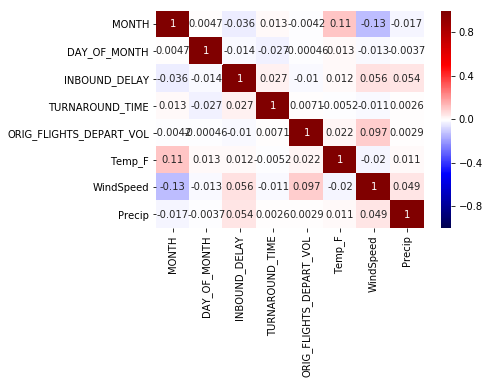

In [371]:
sns.heatmap(X_train.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [372]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr.score(X_train,y_train)

0.14255476175351334

In [373]:
# score fit model on validation data
val_score = lr.score(X_val, y_val)

# report results
print('\nValidation R^2 score was:', val_score)
print('Feature coefficient results: \n')
for feature, coef in zip(X_train.columns, lr.coef_):
    print(feature, ':', f'{coef:.2f}')


Validation R^2 score was: 0.13689531759206397
Feature coefficient results: 

MONTH : -0.15
DAY_OF_MONTH : -0.03
INBOUND_DELAY : 0.34
TURNAROUND_TIME : 0.00
ORIG_FLIGHTS_DEPART_VOL : 0.00
Temp_F : 0.07
WindSpeed : 0.43
Precip : 69.67


In [380]:
# check stats using statsmodel
model = sm.OLS(y_train, sm.add_constant(X_train))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                 6.707e+04
Date:                Mon, 21 Jan 2019   Prob (F-statistic):               0.00
Time:                        15:55:35   Log-Likelihood:            -1.6455e+07
No. Observations:             3227437   AIC:                         3.291e+07
Df Residuals:                 3227428   BIC:                         3.291e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.0279      0.107      9.567      0.000       0.817       1.239
MONTH                      -0.1498      0.007    -22.892      0.000      -0.163      -0.137
DAY_OF_MONTH               -0.0313      0.003    -12.483      0.000      -0.036      -0.026
INBOUND_DELAY               0.3420      0.000    706.291      0.000       0.341       0.343
TURNAROUND_TIME             0.0031      0.001      4.837      0.000       0.002       0.004
ORIG_FLIGHTS_DEPART_VOL  2.482e-06   1.96e-07     12.652      0.000     2.1e-06    2.87e-06
Temp_F                      0.0719      0.001     56.437      0.000       0.069       0.074
WindSpeed                   0.4288      0.005     92.686      0.000       0.420       0.438
Precip                     69.6676      1.027     67.814      0.000      67.654      71.681
==============================================================================
Omnibus:                  5106431.915   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6324871056.242
Skew:                           9.992   Prob(JB):                         0.00
Kurtosis:                     218.949   Cond. No.                     8.84e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.84e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [375]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [ ]:
diagnostic_plot(X_train['INBOUND_DELAY'].values.reshape(-1, 1), y_train) 

In [ ]:
diagnostic_plot(X_train['Precip'].values.reshape(-1, 1), y_train) 

In [ ]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

In [ ]:
lm_reg = Ridge(alpha=1)
cross_val_score(lm_reg, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric